In [63]:
import re
import pickle
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [49]:
df = pd.read_csv('red_edge/red_edge_articles (1).csv')

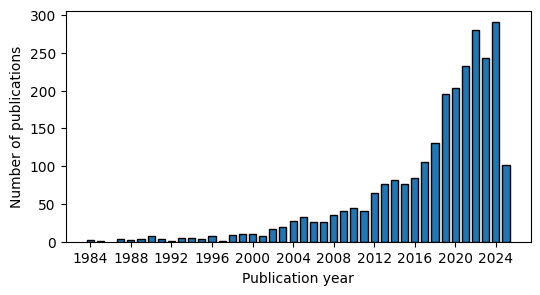

In [57]:
# year_df
fig = plt.figure(figsize=(6,3))
plt.bar(df.groupby('year').count().index, 
        df.groupby('year').count()['abstract'], 
        width=0.7,
        edgecolor='k')
plt.xticks(range(df.year.min(), 2027, 4), range(df.year.min(), 2027, 4))
plt.xlabel('Publication year')
plt.ylabel('Number of publications')
plt.show()

In [64]:
def preprocess2(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens_raw = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    tokens = []
    for word in tokens_raw:
        if word.isalpha() and len(word) > 2 and word not in stop_words:
            lemma_word = lemmatizer.lemmatize(word)
            if lemma_word not in exclude:
                tokens.append(lemma_word)
    
    return tokens


def get_topic_titles(lda_model, topn=3):
    topics = lda_model.show_topics(num_topics=-1, num_words=topn, formatted=False)
    return {topic[0]: " ".join([word for word, _ in topic[1]]) for topic in topics}


# abstracts = df['abstract'].tolist()
with open('yield_dl/abstracts.pkl', 'rb') as f:
    abstracts = pickle.load(f)
lemma = WordNetLemmatizer()
exclude = ['used', 'study', 'introduction', 'methodology', 'method', 'discussion', 
           'red', 'edge', 'vegetation', 'red-edge', 'canopy', 'figure', 'table', 
           'using', 'data', 'spectrum', 'leaf', 'plant', 'result',  'estimation', 'sensor', 
           'area', 'model', 'content', 'image', 'spatial', 'rep', 'wavelength', 
           'difference', 'high', 'different', 'like', 'measurement', 'remote', 
           'sensing', 'one', 'first', 'two', 'three', 'four', 'also', 'use', 'could', 
           'overall', 'higher', 'lower', 'value', 'showed', 'respectively', 'well', 'found', 'obtained',  
           'spectral', 'band', 'reflectance', 'result', 'surface', 'observation', 
           'das', 'org', 'https', 'cambridge', 'fig', 'based']

In [65]:
# Preprocess documents
cleaned_documents = [preprocess2(doc) for doc in abstracts]

# Create a Gensim dictionary (maps words to unique IDs)
dictionary = Dictionary(cleaned_documents)
dictionary.filter_extremes(no_below=5, no_above=0.8)

# Convert documents into Bag-of-Words (BoW) format
corpus = [dictionary.doc2bow(doc) for doc in cleaned_documents]

In [73]:
cohe = []
for n in range(1, 30):
    n_topics = n
    
    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, random_state=42, passes=10, iterations=50)
    coherence_model = CoherenceModel(model=lda_model, texts=cleaned_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(n, coherence_score)
    cohe.append(coherence_score)

1 0.2833666207194712
2 0.36164906724837403
3 0.4136056205488779
4 0.38775179545546734
5 0.3883533602197075
6 0.41252866773780195
7 0.4059623415348241
8 0.41937157327246755
9 0.4240249668836973
10 0.4295272359153589
11 0.4448990250931039
12 0.40527131915136233
13 0.39721626576899455
14 0.4139361992201689
15 0.40420829787628126
16 0.3991779881464395
17 0.39909993355589274
18 0.39665395297113765
19 0.4235399488969382
20 0.3973084060492905
21 0.3903537617750211
22 0.398683895458761
23 0.4136042344689267
24 0.40237197771623245
25 0.39834138491080673
26 0.4083192637158558
27 0.40940754029548115
28 0.40156251972246315
29 0.40091609134255496


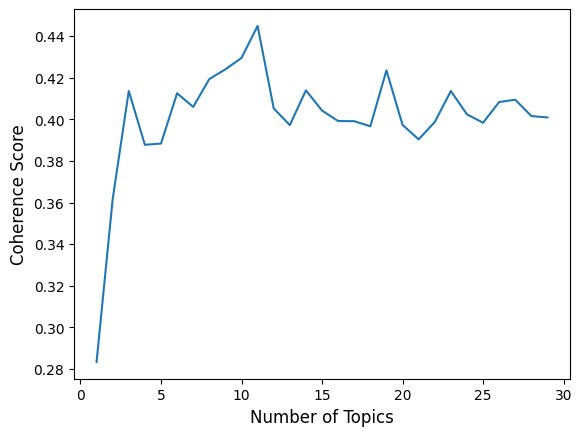

In [74]:
plt.plot(range(1,30), cohe)
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Score", fontsize=12)
plt.show()

In [66]:
# Number of topics
n_topics = 11

# Train the LDA model
lda_model = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, random_state=42, passes=10, iterations=50)

# Print the topics and their top words
for i, topic in lda_model.show_topics(num_topics=n_topics, num_words=6, formatted=False):
    print(f"Topic {i + 1}: {[word for word, prob in topic]}")

Topic 1: ['biomass', 'regression', 'square', 'mean', 'rmse', 'error']
Topic 2: ['feature', 'classification', 'accuracy', 'land', 'sentinel', 'type']
Topic 3: ['specie', 'hyperspectral', 'resolution', 'airborne', 'infrared', 'near']
Topic 4: ['water', 'stress', 'soil', 'specie', 'change', 'region']
Topic 5: ['disease', 'multispectral', 'system', 'agb', 'imagery', 'hyperspectral']
Topic 6: ['chlorophyll', 'concentration', 'correlation', 'parameter', 'hyperspectral', 'nitrogen']
Topic 7: ['soil', 'lai', 'chlorophyll', 'vi', 'parameter', 'chl']
Topic 8: ['crop', 'stage', 'yield', 'growth', 'wheat', 'normalized']
Topic 9: ['earth', 'planet', 'cloud', 'visible', 'coverage', 'life']
Topic 10: ['chlorophyll', 'meris', 'relationship', 'mtci', 'gpp', 'forest']
Topic 11: ['forest', 'sentinel', 'lai', 'tree', 'satellite', 'resolution']


In [67]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(panel)

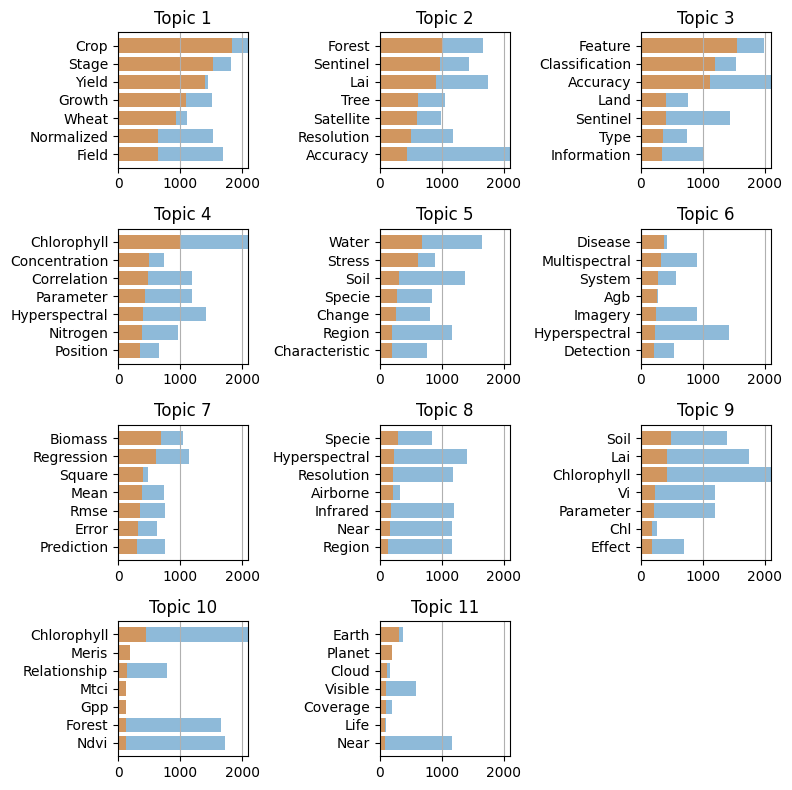

In [68]:
fig, ax = plt.subplots(4, 3, figsize=(8, 8))

for i in range(1, 12):
    df = panel.sorted_terms(i)
    if i < 4:
        j = i - 1
        ax[0, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Total'][::-1], alpha=0.5)
        ax[0, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Freq'][::-1], alpha=0.6)
        ax[0, j].set_title(f"Topic {i}")
        ax[0, j].set_xlim(0, 2100)
        ax[0, j].grid(axis='x')
        
    elif (i >= 4) & (i < 7):
        j = i - 4
        ax[1, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Total'][::-1], alpha=0.5)
        ax[1, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Freq'][::-1], alpha=0.6)
        ax[1, j].set_title(f"Topic {i}")
        ax[1, j].set_xlim(0, 2100)
        ax[1, j].grid(axis='x')
        
    elif (i >= 7) & (i < 10):
        j = i - 7
        ax[2, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Total'][::-1], alpha=0.5)
        ax[2, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Freq'][::-1], alpha=0.6)
        ax[2, j].set_title(f"Topic {i}")
        ax[2, j].set_xlim(0, 2100)
        ax[2, j].grid(axis='x')
        
    else:
        j = i - 10
        ax[3, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Total'][::-1], alpha=0.5)
        ax[3, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Freq'][::-1], alpha=0.6)
        ax[3, j].set_title(f"Topic {i}")
        ax[3, j].set_xlim(0, 2100)
        ax[3, j].grid(axis='x')
        

    ax[3, 2].axis('off')
            
plt.tight_layout()
plt.show()

In [69]:
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]
most_likely_topics = [max(topics, key=lambda x: x[1])[0] for topics in topic_distributions]
all_probabilities = [prob for topics in topic_distributions for _, prob in topics]
topic_titles = get_topic_titles(lda_model)

In [70]:
# Set threshold as the 90th percentile of all topic probabilities
threshold = np.percentile(all_probabilities, 50)

# threshold = 0.02
co_occurrence_matrix = Counter()
for topics in topic_distributions:
    top_topics = [topic[0] for topic in topics if topic[1] > threshold]  # Use a threshold for multiple topics
    co_occurrence_matrix.update(combinations(top_topics, 2))

# Example: Heatmap visualization
topics = list(range(lda_model.num_topics))
print(topics, topic_titles)
matrix = np.zeros((len(topics), len(topics)))
for (t1, t2), count in co_occurrence_matrix.items():
    matrix[t1, t2] = count
    matrix[t2, t1] = count

matrix0 = np.where(matrix == 0, 1, 0)
mask = np.triu(np.ones_like(matrix, dtype=bool))
matrix1 = np.where((matrix * ~mask == 0), np.nan, matrix * ~mask)
matrix1 = np.where(matrix0 == 1, 0, matrix1)# matrix = matrix.mask(mask)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] {0: 'biomass regression square', 1: 'feature classification accuracy', 2: 'specie hyperspectral resolution', 3: 'water stress soil', 4: 'disease multispectral system', 5: 'chlorophyll concentration correlation', 6: 'soil lai chlorophyll', 7: 'crop stage yield', 8: 'earth planet cloud', 9: 'chlorophyll meris relationship', 10: 'forest sentinel lai'}


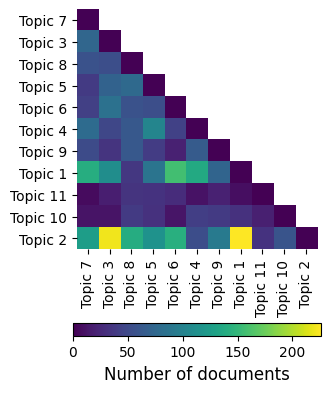

In [71]:
fig, ax = plt.subplots()
im=ax.imshow(matrix1, cmap='viridis')
labels = ['Topic 7', 'Topic 3', 'Topic 8', 'Topic 5', 'Topic 6',
          'Topic 4', 'Topic 9', 'Topic 1', 'Topic 11', 'Topic 10',
          'Topic 2']#, 'Topic 2', 'Topic 9', 'Topic 8', 'Topic 1',]
cb = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.5, pad=0.2)
cb.set_label('Number of documents', fontsize=12)
ax.set_xticks(range(11), labels)#['4', '5', '1', '3', '2'])
ax.set_yticks(range(11), labels)
ax.tick_params(axis='x', rotation=90)
for spine in ax.spines.values():
    spine.set_visible(False)


plt.show()

C:\Users\ignis\AppData\Local\Temp\ipykernel_15436\1664577507.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


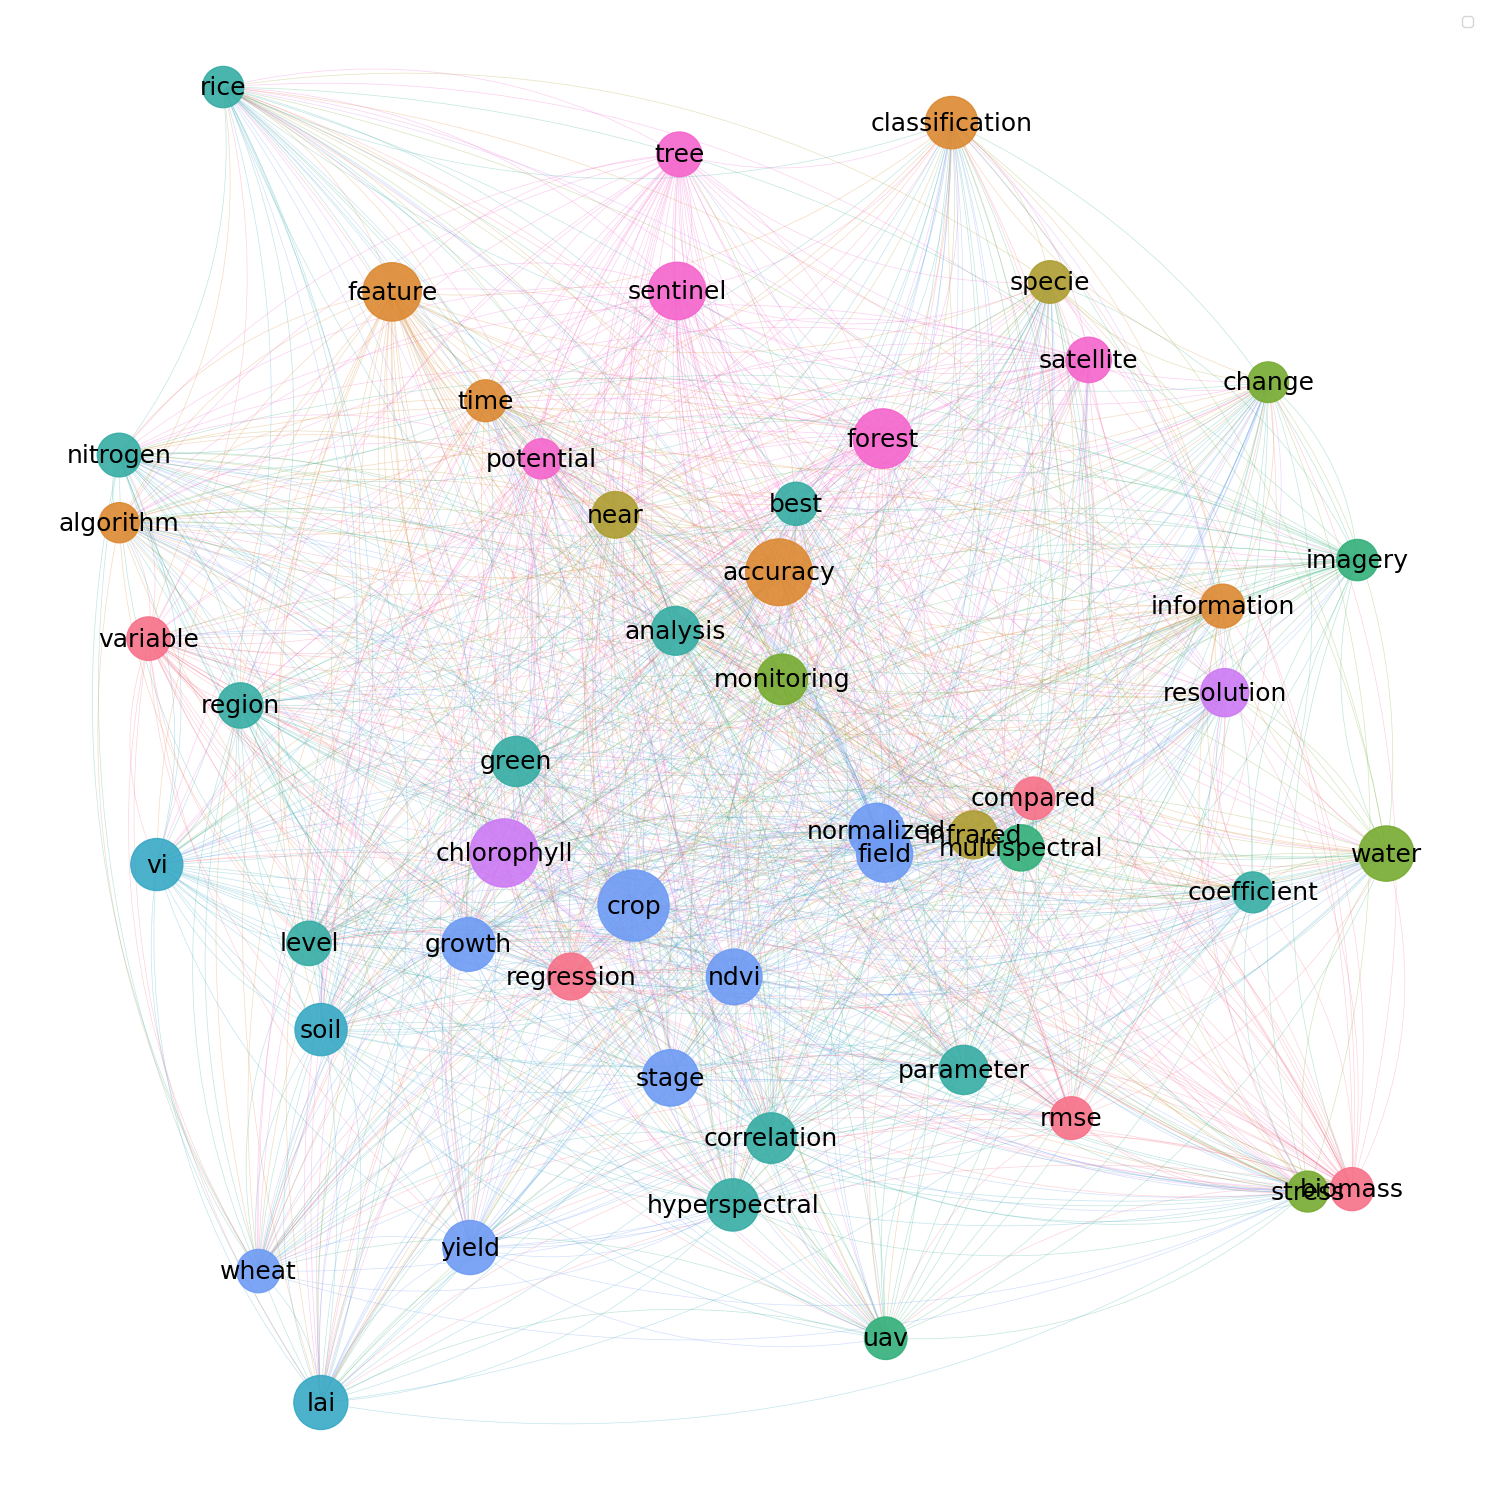

In [72]:
import networkx as nx
from collections import defaultdict
import seaborn as sns
from matplotlib.patches import FancyArrowPatch

# Step 1: Term frequency
term_freq = defaultdict(int)
for doc in corpus:
    for token_id, freq in doc:
        term_freq[token_id] += freq

# Step 2: Top N frequent words
top_N = 50
top_token_ids = sorted(term_freq.items(), key=lambda x: x[1], reverse=True)[:top_N]
top_words_set = {dictionary[token_id] for token_id, _ in top_token_ids}

# Step 3: Co-occurrence matrix
co_occurrence = defaultdict(int)
for doc in cleaned_documents:
    filtered_words = [w for w in doc if w in top_words_set]
    for w1, w2 in combinations(set(filtered_words), 2):
        pair = tuple(sorted((w1, w2)))
        co_occurrence[pair] += 1

# Step 4: Create graph
G = nx.Graph()
for (w1, w2), weight in co_occurrence.items():
    if weight > 1:
        G.add_edge(w1, w2, weight=weight)

# Step 5: Assign LDA topic to each node
lda_topics = {}
for word in G.nodes():
    try:
        word_bow = dictionary.doc2bow([word])
        word_topics = lda_model.get_document_topics(word_bow, minimum_probability=0.0)
        lda_topics[word] = max(word_topics, key=lambda x: x[1])[0]
    except:
        lda_topics[word] = -1

# Step 6: Map topics to colors
colors = [lda_topics.get(node, -1) for node in G.nodes()]
unique_topics = sorted(set(c for c in colors if c >= 0))
cmap = sns.color_palette("husl", len(unique_topics))
topic_to_color = {topic: cmap[i] for i, topic in enumerate(unique_topics)}
node_colors = [topic_to_color.get(lda_topics.get(node, -1), (0.5, 0.5, 0.5)) for node in G.nodes()]

# Step 7: Node sizes by frequency
node_sizes = [term_freq[dictionary.token2id[n]] * 1 for n in G.nodes()]

# Step 8: Draw manually
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.15, seed=42)

# Draw curved edges manually
ax = plt.gca()
for u, v in G.edges():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    color = topic_to_color.get(lda_topics.get(u, -1), (0.5, 0.5, 0.5))
    arrow = FancyArrowPatch((x1, y1), (x2, y2),
                            connectionstyle="arc3,rad=0.2",
                            color=color,
                            linewidth=0.5,
                            alpha=0.3,
                            arrowstyle='-')
    ax.add_patch(arrow)

# Draw nodes
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       alpha=0.9,)
                       # label=['Topic {}'.format(n) for n in range(1, 16)])

# Labels
nx.draw_networkx_labels(G, pos, font_size=18)

plt.axis('off')
plt.tight_layout()
plt.legend()
plt.show()